In [1]:
import pandas as pd
import numpy as np
import math
from collections import OrderedDict
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import copy

In [2]:
data = pd.read_csv("data.csv")
#data

In [3]:
def mean_square_error(original,predicted):
    return np.square(np.subtract(original,predicted)).mean()

y_label = data['xAttack']
new_data = copy.deepcopy(data)
data = data.drop(labels = 'xAttack',axis = 1)

original_array = np.array(data)

col_mean = np.mean(original_array,axis = 0)
std_div = np.std(original_array,axis = 0)

for i in range(original_array.shape[0]):
    original_array[i] = (original_array[i] - col_mean)
    original_array[i] = original_array[i]/std_div

covariance = np.cov(original_array,rowvar= False)

eigen_val,eigen_vec = np.linalg.eig(covariance)

ids = eigen_val.argsort()[::-1] # sorting in descending order
#print(ids)

eigen_val = eigen_val[ids]
eigen_vec = eigen_vec[:,ids]

eigen_sum = sum(eigen_val)

total_sum = 0
# for i in range(len(ids)):
#     projections = np.matmul(original_array,eigen_vec[:,:i])
#     reconstructed_data = np.matmul(projections,eigen_vec[:,:i].T)
#     mean_error = mean_square_error(original_array,reconstructed_data)
#     print(mean_error)

projections = np.matmul(original_array,eigen_vec[:,:15])
#print(projections)

cluster_no = 5
iter_count = 1000

# finiding the number of unique output labels
unique_output = y_label.unique()

label_map = {}

for i in range(5):
    # Assigning output label as 0,1,2,3 and 4
    label_map[unique_output[i]] = i


centroids = dict()
output_label = dict()

centroids[0] = projections[0]
centroids[1] = projections[1]
centroids[2] = projections[2]
centroids[3] = projections[3]
centroids[4] = projections[4]
# Randomly assigning initial centroids

for i in range(iter_count):
    cluster = dict()
    output_label.clear()
    
    for j in range(cluster_no):
        cluster[j] = list()
        output_label[j] = list()
        
        for k in range(cluster_no):
            output_label[j].append(0)
        
    for j,l in zip(projections,range(projections.shape[0])):
        dist = []
        for cen in centroids:
            dist.append(np.linalg.norm(j - centroids[cen]))
            
        classify = dist.index(min(dist))
        cluster[classify].append(j)
            
        output_label[classify][label_map[y_label[l]]]+= 1
        
    previous_value = {}
        
    for j in range(cluster_no):
        previous_value[j] = centroids[j]
        average = np.mean(cluster[j],axis = 0)
        centroids[j] = average
        
    convergence_test = True
        
    for j in range(cluster_no):
        if np.sum(abs(previous_value[j] - centroids[j])/abs(centroids[j]) * 100) > 0.001:
            convergence_test = False
        
    if convergence_test == True:
        break
        
    print(i)

for iteration in range(cluster_no):
    total = np.sum(output_label[iteration])
    max_value = max(output_label[iteration])
    
    print("Purity of cluster ",max_value/total)


avg_purity = 0.0
for i in range(cluster_no):
    total = np.sum(output_label[i])
    max_value = max(output_label[i])
    cluster_purity = max_value/total
    percent = (total * cluster_purity)/float(len(new_data))
    avg_purity = avg_purity + percent

print("Average Purity is : ",avg_purity)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Purity of cluster  0.5220165922144224
Purity of cluster  0.4617467840216655
Purity of cluster  0.9732338308457712
Purity of cluster  0.786692759295499
Purity of cluster  0.992992700729927
Average Purity is :  0.863229058324666


# Part 3

In [4]:
GMM = GaussianMixture(n_components=5)
clusters = GMM.fit_predict(projections)
new_data['clusters'] = clusters
dict_max = {}
average = 0.0
for i in range(5):
    t = new_data[new_data['clusters'] == i]
    #print(t)
    dict_max[i] = t.groupby('xAttack')['clusters'].count().idxmax()
    percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    average = average + (percent * len(t))/len(new_data)
    
    print("Cluster with label",dict_max[i] + " purity percentage is ",str(percent))

print("Average Purity is : ",average)

Cluster with label dos purity percentage is  1.0
Cluster with label normal purity percentage is  0.4940079893475366
Cluster with label normal purity percentage is  0.4906244310941198
Cluster with label normal purity percentage is  0.8622936576889662
Cluster with label r2l purity percentage is  0.6666666666666666
Average Purity is :  0.7941835346827747


# Part 4

In [5]:
clustering = AgglomerativeClustering(n_clusters=5,linkage='single')
clusters = clustering.fit_predict(projections)
new_data['clusters'] = clusters
dict_max = {}
average1 = 0.0
for i in range(5):
    t = new_data[new_data['clusters'] == i]
    #print(t)
    dict_max[i] = t.groupby('xAttack')['clusters'].count().idxmax()
    percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    average1 = average1 + (percent * len(t))/len(new_data)
    
    print("Cluster with label",dict_max[i] + " purity percentage is ",str(percent))

print("Average Purity is : ",average1)

Cluster with label normal purity percentage is  0.5346352395053824
Cluster with label probe purity percentage is  1.0
Cluster with label r2l purity percentage is  0.6666666666666666
Cluster with label normal purity percentage is  1.0
Cluster with label normal purity percentage is  1.0
Average Purity is :  0.5347227778222257


# Plotting the Pie-Chart

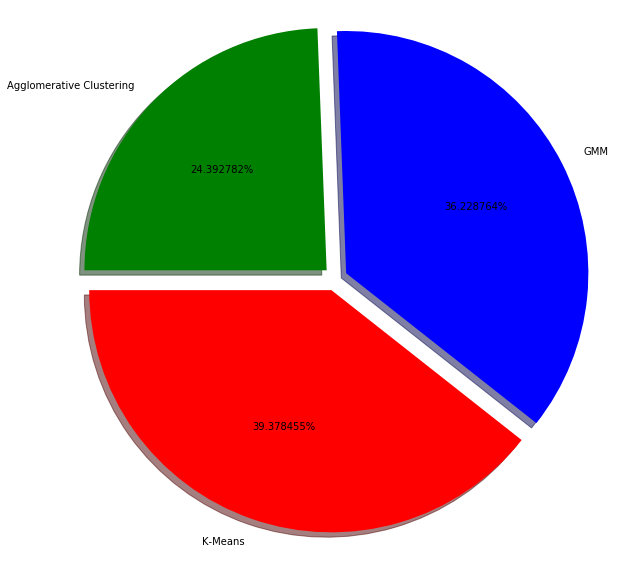

In [7]:
import matplotlib.pyplot as plt
labels = 'K-Means', 'GMM', 'Agglomerative Clustering'
input_list = [avg_purity,average,average1]
colors = ['red','blue','green']
explode = (0.05, 0.05, 0.05)
 
plt.figure(figsize=(10,10))
plt.pie(input_list, explode=explode, labels=labels, colors=colors,
autopct='%f%%', shadow=True, startangle=180)
 
plt.axis('equal')
plt.show()
